**Modified by AT101037 廖健凱**

----
這篇 Notebook 是針對 kaggle的 House Prices: Advanced Regression Techniques 給的實作說明。<br>
https://www.kaggle.com/c/house-prices-advanced-regression-techniques <br>

這裡主要是參考這位作者對這題的作法：<br>
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard<br>

大家如果往後在做 kaggle 題目的時候，如果那題已經有釋放 code，可以多看看好的 code 如何解題，這會對我們的學習很有幫助！<br>

大家可以把這個 notebook 放在 hub 裡，你自己的 v2-5-machine-learning 資料夾下的:<br>

Kaggle_practice/house_prices_advanced_regression_techniques/ 這個路徑裡面，就可以跑了。<br>

---

# Importing packages

In [16]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import os.path
warnings.filterwarnings('ignore')
%matplotlib inline

----
我們要使用一個package之前都需要先將package import進來<br>
import 的方法很簡單，就直接打import就可以了<br>
然後後面的 as 其實可有可無<br>
只是因為使用package的時候需要將package的名字打在前面, 像是<br>
```python
numpy.array()
```
而 as 的用途就是可以少打幾個字<br>
如果只是打個幾行code可能感覺還好<br>
但是當程式碼數量增加的時候 as 可以幫你省下很多時間<br>

這三個是我們最常使用的packages<br>
numpy 對於數學運算的支援非常完整<br>
pandas 對於資料整理上面非常完整<br>
matplotlib 是專門拿來做圖用的package<br>
其他常用的package，像是tensorflow scikit-learn <br>
這些package對於機器學習與深度學習支援很好<br>
之後我們也都會看情況而決定使用不同的package<br>

順帶一提 這個是jupyter一些好用的指令<br>
https://www.cheatography.com/weidadeyue/cheat-sheets/jupyter-notebook/pdf_bw/

---

# Parameters

In [97]:
path_train_data = './train.csv'
path_test_data = './test.csv'
path_sample_submission = './sample_submission.csv'

# Reading Data

In [18]:
if not os.path.exists(path_train_data):
    !gdown --id '1JJ2L7Qs2wIHhxxvbP7-8uGM82UqN1z8T' --output train.csv
if not os.path.exists(path_test_data):
    !gdown --id '1G1JKSpAY8Nkp_Xm0eXUiO5SjdUB-X7T-' --output test.csv

#Read train data and test data
df_train = pd.read_csv(path_train_data)
df_test = pd.read_csv(path_test_data)

df_train, df_test

(        Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
 0        1          60       RL  ...        WD         Normal    208500
 1        2          20       RL  ...        WD         Normal    181500
 2        3          60       RL  ...        WD         Normal    223500
 3        4          70       RL  ...        WD        Abnorml    140000
 4        5          60       RL  ...        WD         Normal    250000
 ...    ...         ...      ...  ...       ...            ...       ...
 1455  1456          60       RL  ...        WD         Normal    175000
 1456  1457          20       RL  ...        WD         Normal    210000
 1457  1458          70       RL  ...        WD         Normal    266500
 1458  1459          20       RL  ...        WD         Normal    142125
 1459  1460          20       RL  ...        WD         Normal    147500
 
 [1460 rows x 81 columns],
         Id  MSSubClass MSZoning  ...  YrSold  SaleType SaleCondition
 0     1461          20  

----
通常用read_csv就可以正常讀出資料<br>
只是有時候資料分割的方式不同可能會出現一些問題<br>
再遇到這種情況的時候可以把csv檔案打開<br>
如果發現檔案不是用逗號 , 做分割的時候<br>
那就要自己改sep<br>
像是如果發現資料是用空白做分割的時候<br>
就要改成<br>
```python
training_set = pd.read_csv('Data/train.csv', sep=' ')
```

---

In [19]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [20]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [21]:
print('The shape of df_train:', df_train.shape)
print('The shape.of df_test:', df_test.shape)

The shape of df_train: (1460, 81)
The shape.of df_test: (1459, 80)


In [22]:
train_ID = df_train['Id']
test_ID = df_test['Id']

#Drop the Id columns in training and testing data
df_train.drop('Id', axis = 1, inplace = True)
df_test.drop('Id', axis = 1, inplace = True)

print('The shape of df_train:', df_train.shape)
print('The shape.of df_test:', df_test.shape)

The shape of df_train: (1460, 80)
The shape.of df_test: (1459, 79)


----
從以上觀察，我們可以知道 df_train 的最後一行 SalePrice 欄位，即為我們要預測的 traget value (房價)。<br>
此外，還可以看到資料當中，有些資料型態並非數值型態資料（也就是屬於字串），同時也有缺失值(NaN)存在的情況。<br>

為了要將資料送進機器學習的 model 中，我們要先將非數值類型的資料轉成數值類型。<br>
同時，缺失值也必須進行處理，不可以讓欄位是呈現 NaN 狀態，所以要進行剃除或補值的動作。<br>

---

# Data Preprocessing

----
Data Preprocessing（資料前處理），這應該可以說是最需要耐心的部份。<br>

在這邊大致可分為兩部份，前半部份算是一些對資料的觀察、分析(EDA)，後半部主要是針對缺失值及非數值類資料的處理。<br>
而重點應該是在後半部份，因為至少要當缺失值及字串類資料處理好時，我們才能將資料送進 model。

---

### Exploratory Data Analysis (EDA)

In [23]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

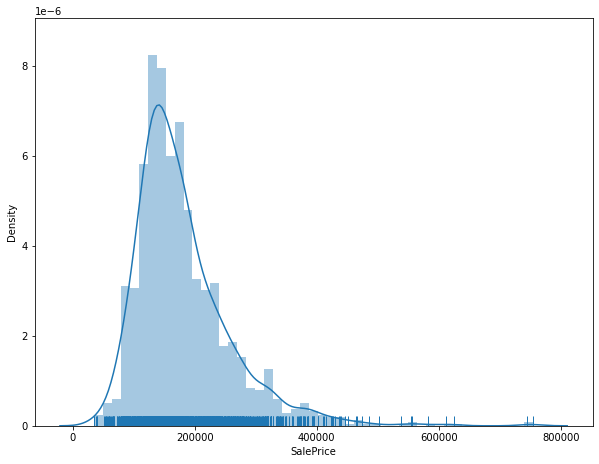

In [24]:
#histogram
f, ax = plt.subplots(figsize=(10, 7.5))
sns.distplot(df_train['SalePrice'], rug=True)

In [25]:
#skewness and kurtosis
print("Skewness: {:.2f}".format(df_train['SalePrice'].skew()))
print("Kurtosis: {:.2f}".format(df_train['SalePrice'].kurt()))

Skewness: 1.88
Kurtosis: 6.54


----
發現房價有右偏的情況，為避免極端離群值對模型預測的影響，這邊我們對 target value 取 log(x)或者也可以取 log(1+x)。<br>
log 函數具有將大數變小的效果，如此做可以把右端離群值拉回使 target value 更為集中。<br>
<img src="./LogarithmicFunction.png" width="400" height="250">

下圖可說明極端離群值對 regression 的影響<br>
<img src="http://cdn-0.r-statistics.co/screenshots/outliers_effect.png" width="698" height="349">
---

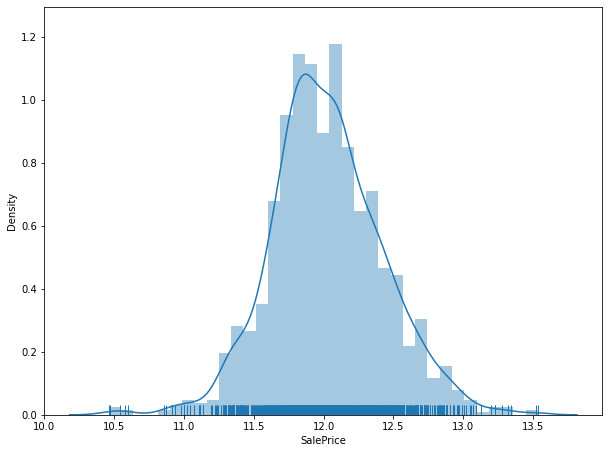

In [26]:
log_SalePrice = np.log1p(df_train['SalePrice'])
# Take y=log(1+x) on 'SalePrice'

#histogram
f, ax = plt.subplots(figsize=(10, 7.5))
sns.distplot(log_SalePrice, rug=True)

In [27]:
#skewness and kurtosis
print("Skewness: {:.2f}".format(log_SalePrice.skew()))
print("Kurtosis: {:.2f}".format(log_SalePrice.kurt()))

Skewness: 0.12
Kurtosis: 0.81


----
kurtosis 高低的意義代表極端離群值的多寡。<br>
[Kurtosis Wiki](https://en.wikipedia.org/wiki/Kurtosis)<br>
[Kurtosis as Peakedness, 1905-2014. RIP](https://www.researchgate.net/publication/264829715_Kurtosis_as_Peakedness_1905-2014_RIP)<br>
[Pandas Kurtosis](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.kurt.html)<br>

---

----
我們也可以將每一個 feature 之間的線型相關係數以熱圖的形式表現出來。<br>
顏色愈淺的就代表正相關性愈強，顏色愈深就代表負相關性愈強。<br>

---

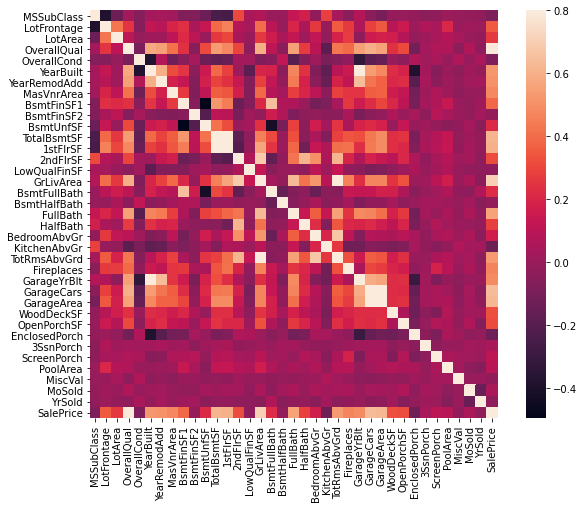

In [28]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(10, 7.5))
sns.heatmap(corrmat, vmax=.8, square=True)

----
觀察以上的熱圖，最後一列代表的就是 SalePrice 跟其他特徵之間的相關性強弱，且我們發現 OverallQual 這一行顏色最淺。<br>
這引發了我們的好奇心，想看看 SalePrice 跟 OverallQual 這個特徵之間的關係。<br>

所以，以下我們就來稍微觀察一下。

---

In [29]:
df_train[['OverallQual']].head()

,OverallQual
0,7
1,6
2,7
3,7
4,8


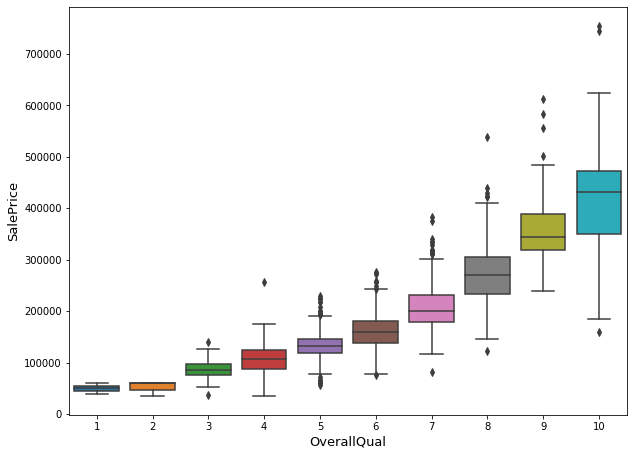

In [30]:
f, ax = plt.subplots(figsize=(10, 7.5))

sns.boxplot(x = df_train['OverallQual'],y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize = 13)
plt.xlabel('OverallQual', fontsize = 13)

plt.show()

----
可以發現 OverallQual 資料屬於離散型的資料型態。<br>
這時候我們可以再去查看 OverallQual 這特徵代表的意思是什麼？<br>

查看特徵代表的意思，可以從網站 https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data 裡的 data_description.txt 得知。<br>
查看後得知 OverallQual 代表 Rates the overall material and finish of the house 共分為：<br>

10 &nbsp;Very Excellent<br>
9 &emsp;Excellent<br>
8 &emsp;Very Good<br>
7 &emsp;Good<br>
6 &emsp;Above Average<br>
5 &emsp;Average<br>
4 &emsp;Below Average<br>
3 &emsp;Fair<br>
2 &emsp;Poor<br>
1 &emsp;Very Poor<br>

這跟我們一般的認知相同，房價會從 OverallQual 的等級反應出來。

---

### Missing Data Processing

----
這邊用偷懶的做法，在開始之前我們要先將 training data 和 testing data 合併。<br>

---

In [31]:
# 先將 SalePrice 獨立出來
SalePrice = df_train['SalePrice']

#Drop the SalePrice column in training data
df_train.drop('SalePrice', axis = 1, inplace = True)

#Concatenate training dataframe and testing dataframe anlog axis_0
df = pd.concat([df_train, df_test])

In [32]:
df.shape

(2919, 79)

----
這裡可以用 pandas 的 isna() 方法查看有缺失值的欄位。<br>
我們將有缺失值的欄位統整由多到少排列出來，可以看到第35列缺失值數量已經為0，因此有缺失值的欄位共有34個。<br>

---

In [33]:
#Detect missing data
total = df.isna().sum(axis = 0).sort_values(ascending = False)
percent = df.isna().sum(axis = 0).sort_values(ascending = False)/df.shape[0]

missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
#missing_data = pd.concat([total, percent], axis = 1, keys = ['Total'])
missing_data.head(35)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


----
我們知道目前資料類型有分為數值型與非數值型，我們可以先將這兩種不同型態的資料區分出來，各別對其缺失值做處理。<br>
可用 select_dtypes(include=None, exclude=None) 將我們要的資料類型抽取出來。<br>
若需要數值型，我們就讓 include = np.number。<br>
若需要的資料是屬於字串類，我們就讓 include = 'object'<br>

這裡我們先處理數值型的缺失資料。<br>

---

In [34]:
#Extract data type of numbers from features
df_num = df.select_dtypes(include = np.number)

num_total = df_num.isna().sum(axis = 0).sort_values(ascending = False)
num_percent = df_num.isna().sum(axis = 0).sort_values(ascending = False)/df.shape[0]

num_missing_data = pd.concat([num_total, num_percent], axis = 1, keys = ['Total', 'Percent'])
num_missing_data.head(12)

,Total,Percent
LotFrontage,486,0.166495
GarageYrBlt,159,0.054471
MasVnrArea,23,0.007879
BsmtHalfBath,2,0.000685
BsmtFullBath,2,0.000685
GarageArea,1,0.000343
BsmtFinSF1,1,0.000343
BsmtFinSF2,1,0.000343
BsmtUnfSF,1,0.000343
TotalBsmtSF,1,0.000343


----
我們再把數值類帶有缺失值的特徵重新做一次線型相關的熱圖。<br>
這次可以再更仔細的看一下每一個 feature 之間的相關性如何。<br>

特別是，我們可以先注意缺失值數量最多的特徵 LotFrontage 與 SalePrice 之間的關係。<br>
可以看到，這兩者之間似乎是有些正相關。<br>

---

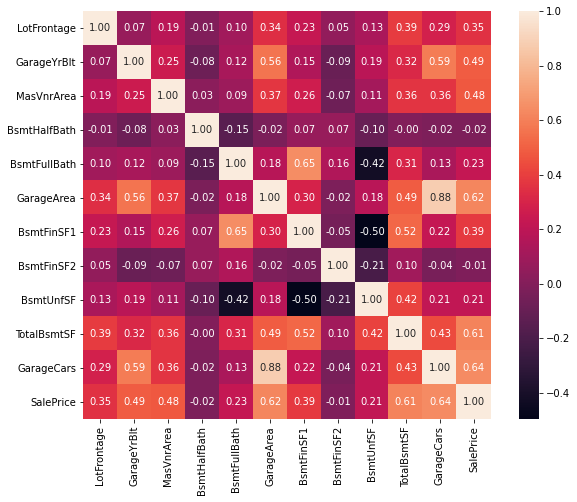

In [35]:
num_mis_feat = df_train[['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 
                          'GarageArea', 'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF', 'GarageCars']]

num_mis_df = pd.concat([num_mis_feat, SalePrice], axis = 1)

corrmat_Num_Mis = num_mis_df.corr()
f, ax = plt.subplots(figsize=(10, 7.5))
sns.heatmap(corrmat_Num_Mis, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})

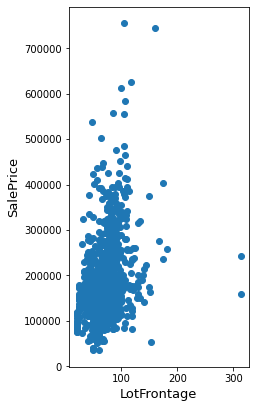

In [36]:
fig = plt.figure(figsize=(2.5, 5))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.001, wspace=0.5)

plt.subplot()
plt.scatter(x = df_train['LotFrontage'], y = SalePrice)
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotFrontage', fontsize=13)

plt.show()

----
根據 https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard 這篇作者的描述，<br>
作者認為：「the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood」，<br>
因此我們可以用 Neighborhood 這項特徵來分類 LotFrontage 並取其分類後的 median 用以補缺失值。 

---

In [37]:
df[['Neighborhood']].describe()

,Neighborhood
count,2919
unique,25
top,NAmes
freq,443


----
把 LotFrontage 依據 Neighborhood 為劃分的盒圖畫出。<br>
觀察看看<br>

---

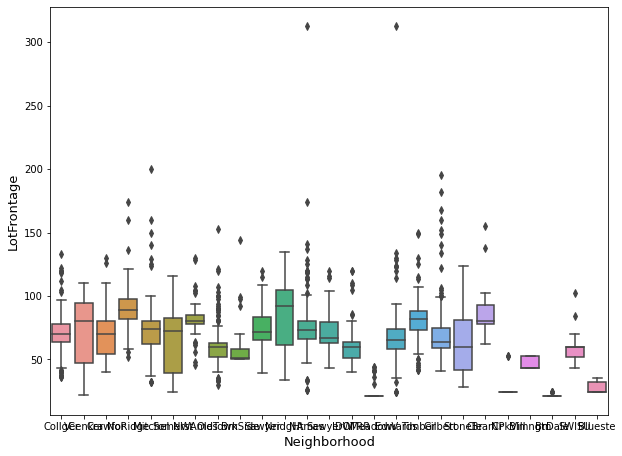

In [38]:
f, ax = plt.subplots(figsize=(10, 7.5))

sns.boxplot(x = df['Neighborhood'],y = df['LotFrontage'])
plt.ylabel('LotFrontage', fontsize = 13)
plt.xlabel('Neighborhood', fontsize = 13)

plt.show()

----
這邊將缺失值以中位數填入。

---

In [39]:
df['LotFrontage'] = df.groupby("Neighborhood")['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [40]:
df[['LotFrontage']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  2919 non-null   float64
dtypes: float64(1)
memory usage: 125.6 KB


----
開始檢查第二個有缺失值的特徵 GarageYrBlt。<br>
這項特徵的描述是車庫建造的年份，首先一個想法是這裡車庫建造年份的缺失會不會是因為這住家沒有車庫的關係，或是只是單純在收資料的時候遺漏了？<br>

我們將 GarageYrBlt 是 NaN 時其他跟 Garage 有關的特徵列出來。<br>

我們發現其他跟 Garage 有關的特徵也同時為 NaN，所以我們將這些 Na 值填上 0。<br>

---

In [41]:
df[df['GarageYrBlt'].isna() == True][['GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond']].head(10)

,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,NaN,NaN,0.0,0.0,NaN,NaN
48,NaN,NaN,0.0,0.0,NaN,NaN
78,NaN,NaN,0.0,0.0,NaN,NaN
88,NaN,NaN,0.0,0.0,NaN,NaN
89,NaN,NaN,0.0,0.0,NaN,NaN
99,NaN,NaN,0.0,0.0,NaN,NaN
108,NaN,NaN,0.0,0.0,NaN,NaN
125,NaN,NaN,0.0,0.0,NaN,NaN
127,NaN,NaN,0.0,0.0,NaN,NaN
140,NaN,NaN,0.0,0.0,NaN,NaN


In [42]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

----
接下來我們查看 MasVnrArea 特徵。<br>
先用 describe() 來檢查，可以看到這項特徵的數值以 0 居多。<br>

---

In [43]:
df[['MasVnrArea']].describe()

,MasVnrArea
count,2896.000000
mean,102.201312
std,179.334253
min,0.000000
25%,0.000000
50%,0.000000
75%,164.000000
max,1600.000000


----
我們再用分佈圖來看一下。<br>
確認之後，由於這項特徵有缺失的欄位是 23 個，數量上沒有到特別多，在這邊我們就直接將缺失值填入 0。<br>

---

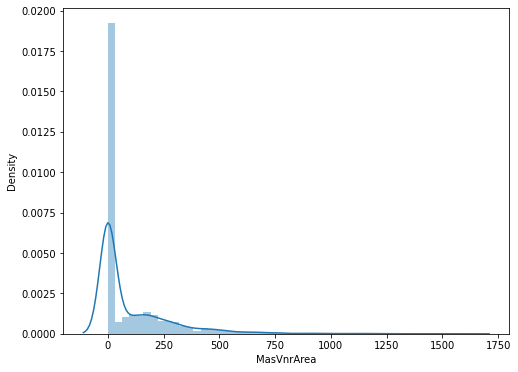

In [44]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df['MasVnrArea'].dropna(), rug=False)

In [45]:
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)

----
接下來我們來看跟 Bsmt 有關的特徵。<br>


---

In [46]:
df[['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath']].describe()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtHalfBath,BsmtFullBath
count,2918.000000,2918.000000,2918.000000,2918.000000,2917.000000,2917.000000
mean,441.423235,49.582248,560.772104,1051.777587,0.061364,0.429894
std,455.610826,169.205611,439.543659,440.766258,0.245687,0.524736
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,220.000000,793.000000,0.000000,0.000000
50%,368.500000,0.000000,467.000000,989.500000,0.000000,0.000000
75%,733.000000,0.000000,805.500000,1302.000000,0.000000,1.000000
max,5644.000000,1526.000000,2336.000000,6110.000000,2.000000,3.000000


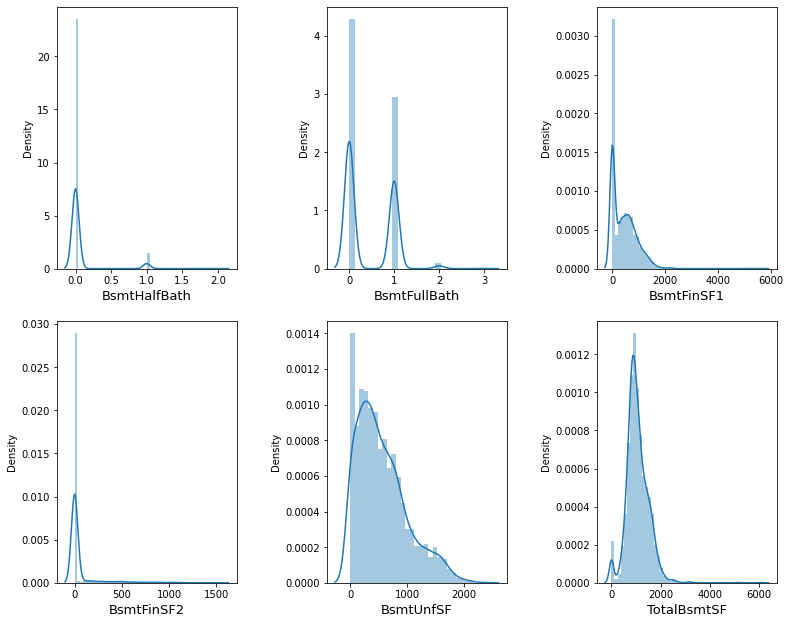

In [47]:
fig = plt.figure(figsize=(10, 8))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.5)

plt.subplot(231)
sns.distplot(df['BsmtHalfBath'].dropna(), rug=False)
plt.xlabel('BsmtHalfBath', fontsize=13)

plt.subplot(232)
sns.distplot(df['BsmtFullBath'].dropna(), rug=False)
plt.xlabel('BsmtFullBath', fontsize=13)

plt.subplot(233)
sns.distplot(df['BsmtFinSF1'].dropna(), rug=False)
plt.xlabel('BsmtFinSF1', fontsize=13)

plt.subplot(234)
sns.distplot(df['BsmtFinSF2'].dropna(), rug=False)
plt.xlabel('BsmtFinSF2', fontsize=13)

plt.subplot(235)
sns.distplot(df['BsmtUnfSF'].dropna(), rug=False)
plt.xlabel('BsmtUnfSF', fontsize=13)

plt.subplot(236)
sns.distplot(df['TotalBsmtSF'].dropna(), rug=False)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()

----
可以看到，這幾項特徵的數值都有 0，且有些特徵擁有的 0 值較多（BsmtHalfBath、BsmtFullBath、BsmtFinSF1、BsmtFinSF2），有些較少（BsmtUnfSF、TotalBsmtSF）。<br>
不過這些特徵的缺失數量都很少（1 or 2），所以我們直接將缺失資料填入 0。

---

In [48]:
for col in ['BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath']:
    df[col] = df[col].fillna(0)

----
還剩最後 2 個數值型的缺失資料要處理，分別是 GarageArea 和 GarageCars。<br>

---

In [49]:
df[[ 'GarageArea','GarageCars']].head()

,GarageArea,GarageCars
0,548.0,2.0
1,460.0,2.0
2,608.0,2.0
3,642.0,3.0
4,836.0,3.0


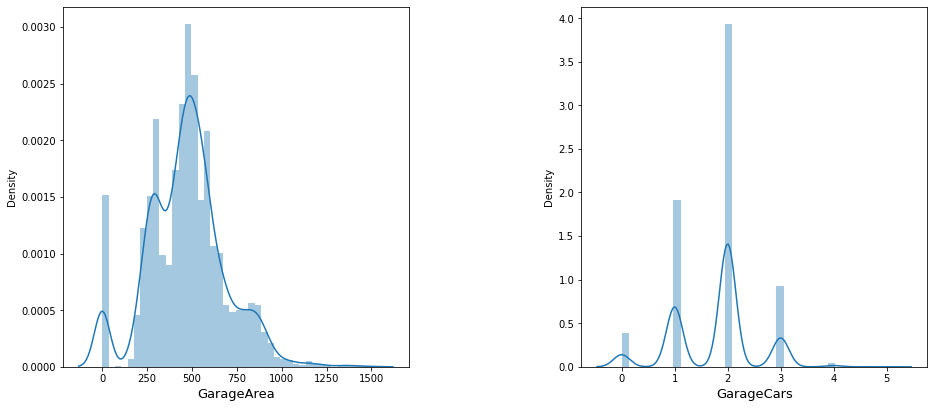

In [50]:
fig = plt.figure(figsize=(12, 5))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.001, wspace=0.5)

plt.subplot(121)
sns.distplot(df['GarageArea'].dropna(), rug=False)
plt.xlabel('GarageArea', fontsize=13)

plt.subplot(122)
sns.distplot(df['GarageCars'].dropna(), rug=False)
plt.xlabel('GarageCars', fontsize=13)

plt.show()

In [51]:
df[(df.GarageArea.isna() ==True) | (df.GarageCars.isna() ==True)][['GarageYrBlt','GarageArea', 'GarageCars']]

,GarageYrBlt,GarageArea,GarageCars
1116,0.0,NaN,NaN


----
由以上觀察，我們也將這 2 個缺失資料令為 0。

---

In [52]:
df['GarageArea'] = df['GarageArea'].fillna(0)
df['GarageCars'] = df['GarageCars'].fillna(0)

----
接下來我們要處理字串型態資料欄位的缺失值。<br>
先用 select_dtypes() 將字串型資料取出。<br>
再將有缺失值特徵的欄位統整列出。

---

In [53]:
#Extract data type of object from features
df_obj = df.select_dtypes(include = 'object')

obj_total = df_obj.isna().sum(axis = 0).sort_values(ascending = False)
obj_percent = df_obj.isna().sum(axis = 0).sort_values(ascending = False)/df.shape[0]

obj_missing_data = pd.concat([obj_total, obj_percent], axis = 1, keys = ['Total', 'Percent'])
obj_missing_data.head(25)

,Total,Percent
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468
GarageCond,159,0.054471
GarageQual,159,0.054471
GarageFinish,159,0.054471
GarageType,157,0.053786
BsmtCond,82,0.028092


----
給定條件將有缺失值的欄位用 index 列出來，方便用來複製貼上。

---

In [54]:
obj_missing_data[obj_missing_data.Total != 0].index

Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageCond',
       'GarageQual', 'GarageFinish', 'GarageType', 'BsmtCond', 'BsmtExposure',
       'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MSZoning',
       'Functional', 'Utilities', 'Electrical', 'KitchenQual', 'SaleType',
       'Exterior2nd', 'Exterior1st'],
      dtype='object')

----
查看 data_description.txt 發現有些特徵填入 NaN 是「沒有」的概念。<br>
因此我們將這些特徵列出，將他們的 Na 值改由 'None' 字串填上。

---

In [55]:
NA_is_None = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageCond',
       'GarageQual', 'GarageFinish', 'GarageType', 'BsmtCond', 'BsmtExposure',
       'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType']

for col in NA_is_None:
    df[col] = df[col].fillna('None')

----
接下來我們要來看 MSZoning 特徵。

---

In [56]:
#Extract data type of object from features
df_obj = df.select_dtypes(include = 'object')

obj_total = df_obj.isna().sum(axis = 0).sort_values(ascending = False)
obj_percent = df_obj.isna().sum(axis = 0).sort_values(ascending = False)/df.shape[0]

obj_missing_data = pd.concat([obj_total, obj_percent], axis = 1, keys = ['Total', 'Percent'])
obj_missing_data.head(10)

,Total,Percent
MSZoning,4,0.001370
Utilities,2,0.000685
Functional,2,0.000685
Electrical,1,0.000343
SaleType,1,0.000343
Exterior2nd,1,0.000343
Exterior1st,1,0.000343
KitchenQual,1,0.000343
Condition2,0,0.000000
RoofMatl,0,0.000000


In [57]:
df[['MSZoning']].describe()

,MSZoning
count,2915
unique,5
top,RL
freq,2265


----
用 describe() 觀察之。<br>
發現這項特徵出現最多次的為 RL 有 2265 次，而我們全部的樣本有 2919 個，且有缺失的樣本數只有 4，故以出現最多次的 RL 填入之。

---

In [58]:
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

----
Functional 這項特徵也是比照 MSZoning 辦理。

---

In [59]:
df[['Functional']].describe()

,Functional
count,2917
unique,7
top,Typ
freq,2717


In [60]:
df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])

----
查看 Utilities 特徵。<br>
freq 2916 代表 AllPub 出現的次數，但全部的 sample 共 2919，故我們認定這是沒用的特徵，刪除之。

---

In [61]:
df[['Utilities']].describe()

,Utilities
count,2917
unique,2
top,AllPub
freq,2916


In [62]:
df.drop('Utilities', axis = 1, inplace = True)

----
查看 Exterior1st、Exterior2nd 這兩項特徵，都只有 1 個缺失值，以最多的值填入。

---

In [63]:
df[['Exterior1st','Exterior2nd']].describe()

,Exterior1st,Exterior2nd
count,2918,2918
unique,15,16
top,VinylSd,VinylSd
freq,1025,1014


In [64]:
df[(df.Exterior1st.isna() ==True) | (df.Exterior2nd.isna() == True)][['Exterior1st', 'Exterior2nd']]

,Exterior1st,Exterior2nd
691,NaN,NaN


In [65]:
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])

----
以下各項特徵的缺失值處理方式也相同：<br>
先以 describe() 查看，若覺得沒太大的問題便以出現最多的值補之。

---

In [66]:
df[['KitchenQual']].describe()

,KitchenQual
count,2918
unique,4
top,TA
freq,1492


In [67]:
df['KitchenQual'] = df['KitchenQual'].fillna(df['KitchenQual'].mode()[0])

In [68]:
df[['SaleType']].describe()

,SaleType
count,2918
unique,9
top,WD
freq,2525


In [69]:
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

In [70]:
df[['Electrical']].describe()

,Electrical
count,2918
unique,5
top,SBrkr
freq,2671


In [71]:
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

----
到目前為止，缺失值的資料已經全部補上。<br>
在處理缺失值時，上面的基本原則是先想辦法補值，不要輕易 drop 掉一個 feature。<br>

除非是那些明顯無用的 feature 可以先 drop。<br>
不然的話可以先試著補值，待在做模型訓練時，再來考慮 feature 的增刪。<br>

由於做模型訓練應該會是個反覆的實驗過程，除了參數的調整以外，我們還會考慮到是否需要增加或減少 feature，來讓模型學得更好。<br>
屆時我們可以再依照我們對資料本身的理解做增刪的動作。<br>

以下我們再檢查一次缺失值是否已經完全補完:

---

In [72]:
df.isna().sum(axis = 0).sort_values(ascending = False).head()

SaleCondition    0
BsmtQual         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
dtype: int64

In [73]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal


# Encoding and Feature Scaling (Data Normalization)

### Label Encoding

----
先將數值型與字串型資料的特徵預備好，以供複製貼上。

---

In [74]:
col_num = df.select_dtypes(include = np.number).columns
col_obj = df.select_dtypes(include = 'object').columns

print('col_num: ', col_num)
print('col_obj: ', col_obj)

col_num:  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
col_obj:  Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 

----
在類別型特徵中，將認為「順序」中會帶有資訊的特徵選出，做 Label Encoding。

---

In [75]:
from sklearn.preprocessing import LabelEncoder


lab_col = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'OverallQual', 'OverallCond',
        'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold', 'MSZoning']

for c in lab_col:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))

### Feature Scaling

----
我們來查看數值型特徵的偏度(skewness)。

---

In [76]:
from scipy import stats
from scipy.stats import norm, skew

num_feats = df.dtypes[df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
LandSlope,4.975157
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694


----
以 Box-Cox Transform 來降低偏度。

有關 Box-Cox Transform 的描述可以參考：<br>

http://onlinestatbook.com/2/transformations/box-cox.html<br>
https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html<br>


---

In [77]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #df[feat] += 1
    df[feat] = boxcox1p(df[feat], lam)
    #df[skewed_features] = np.log1p(df[skewed_features])
    
#df[skewed_features] = np.log1p(df[skewed_features])

There are 59 skewed numerical features to Box Cox transform


In [78]:
skewed_feats = df[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
PoolArea,15.119426
3SsnPorch,8.924822
LowQualFinSF,8.744143
MiscVal,5.597060
LandSlope,4.532036
BsmtHalfBath,3.788243
KitchenAbvGr,3.698825
ScreenPorch,2.978396
BsmtFinSF2,2.564481
EnclosedPorch,2.025461


----
接下來我們做對數值型特徵做 feature scaling。

---

In [79]:
from sklearn.preprocessing import scale

for i in num_feats:
    df[i] = scale(df[i])

----
要注意，做 feature scaling 之前，要先把偏度過大的 feature 做一些降低偏度的轉換。<br>

當某 feature 偏度大時代表該 feature 的資料分佈會有離群值(outlier)的現象，而離群值(outlier)會對一般 scaling 的方法產生不好的影響。<br>
因此我們應當先以 Box-Cox 或其他可降低偏度的轉換，將偏度降低，再做 scaling。<br>

關於 outlier 對 scaling 的影響可參考以下這篇：<br>

https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

---

### One-Hot Encoding

----
使用 get_dummies 做 one-hot encoding。

---

In [80]:
df['MSSubClass'] = df['MSSubClass'].apply(str)

In [81]:
df = pd.get_dummies(df)

In [82]:
df.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.042619,-0.078037,-0.142360,0.064249,0.106585,0.740518,-0.221226,0.678616,-0.427884,0.877164,0.726092,1.178840,-0.514250,0.361875,-0.311783,0.318854,0.567959,-0.273167,0.800337,0.318589,-0.35802,-0.546412,-0.071234,-0.929146,0.26829,-0.784381,1.213985,-0.115984,0.546859,1.130512,-0.251371,0.810002,1.261463,0.251253,-0.202082,-0.205738,1.015942,0.238453,-0.979642,0.061713,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0.042619,0.566375,0.110415,0.064249,0.106585,0.740518,-0.221226,0.039016,1.887067,0.275101,0.079539,-0.779163,0.571524,0.361875,-0.311783,0.318854,-0.880373,-1.808225,0.974460,0.318589,-0.35802,-0.131136,0.421243,-0.929146,0.26829,0.403636,-0.860288,-0.115984,-0.390544,-0.832992,3.881509,0.810002,-0.763816,0.251253,-0.202082,0.660816,-0.213072,0.238453,0.751581,1.453790,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0.042619,0.060159,0.431443,0.064249,0.106585,-1.396325,-0.221226,0.678616,-0.427884,0.837116,0.707760,1.078600,-0.514250,0.361875,-0.311783,0.318854,-0.051483,-0.273167,0.611098,0.318589,-0.35802,0.168081,0.018074,-0.929146,0.26829,-0.568940,1.220803,-0.115984,0.684581,1.130512,-0.251371,0.810002,1.261463,0.251253,-0.202082,-0.205738,-0.213072,0.238453,0.751581,1.453790,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,0.042619,-0.320706,0.099975,0.064249,0.106585,-1.396325,-0.221226,0.678616,-0.427884,-1.999633,-0.138766,-0.779163,0.571524,0.361875,0.869493,-2.386095,0.567959,-1.808225,0.235331,0.318589,-0.35802,0.329970,-0.222843,0.544586,0.26829,-0.437522,1.155039,-0.115984,0.559759,1.130512,-0.251371,-1.027605,-0.763816,0.251253,-0.202082,-0.205738,0.434172,0.238453,0.751581,-0.875875,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,0.042619,0.720948,0.925808,0.064249,0.106585,-1.396325,-0.221226,1.244744,-0.427884,0.816857,0.670196,1.502626,-0.514250,0.361875,-0.311783,0.318854,-2.185684,-0.273167,0.761475,0.318589,-0.35802,0.257325,0.295089,-0.929146,0.26829,0.099312,1.317853,-0.115984,1.354531,1.130512,-0.251371,0.810002,1.261463,1.273610,-0.202082,-0.205738,1.545134,0.238453,0.751581,1.453790,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


# Modeling

----
先將 training data 和 testing data 拆開。<br>

以 training data 來完成 modeling 即訓練。<br>
最後再將 testing data 送進訓練完的 model 來查看結果。

---

In [83]:
df_train = df.iloc[:1460,:]
df_test = df.iloc[1460:,:]

----
不要忘記，還需要再將 validation set 給切分出來。<br>

---

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df_train, log_SalePrice, test_size=0.2, random_state= 12, shuffle=True)
# X_train, X_valid, y_train, y_valid = train_test_split(df_train, SalePrice, test_size=0.2, random_state= 12, shuffle=True)

----
常常會有人搞混testing set 跟validation set的差別<br>
當然sklean的取名只會讓你更混亂<br>
其實應該是要叫train validation split<br>
因為我們分出來的validation是用來確保我們的資料不會overfit<br>
我們會依據validation來對我們的model做調整<br>
但因為我們不想要我們的資料只有在這個validation上面表現得好<br>
所以我們最後會用testing在訓練完成後來計算真正的準確度<br>
如果你覺得我講得不夠好 (如果這樣覺得也不要跟我講我會難過)<br>
你可以參考這篇 它講得非常完整<br>
https://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set<br>
而一般kaggle比賽會幫你先把testing分出來<br>
但是kaggle很邪惡會把testing再分成兩段<br>
一段是你把資料傳上去時顯示的準確度<br>
一段是真正的準確度<br>
這樣做是為了避免比賽的人為了testing的準確度瘋狂條參數<br>
而導致這個model只有在這個testing set上表現得特別好<br>
如果你現在有認真在看前面的程式然後還沒睡著的話<br>
你會發現前面偷偷read進來了一個testing set<br>
但是上面只有features 沒有target value<br>
我們最後的目的就是要用訓練好的model去跑這些資料<br>
然後把我們的prediction上傳到https://www.kaggle.com/c/boston-housing<br>
當然你也不用真的去上傳 <br>
因為這份資料只是要幫助你了解怎麼訓練而已

順帶一提  <br>
請不要直接import sklearn <br>
這個package過大直接import會爆炸

---

----
接下來我們匯入一些 model 來做訓練。<br>
並以 R2 score 來做訓練完後的模型評估(evaluation)。<br>

我們先用一般的 linear model 來看看：

---

In [85]:
from sklearn.linear_model import LinearRegression #選擇模型
from sklearn import metrics

model_linear = LinearRegression()#建立模型
model_linear.fit(X_train,y_train)#訓練模型
pred = model_linear.predict(X_valid)#模型預測
#pred = np.log(pred)
print('R2 score:{:.2f}'.format(metrics.r2_score(y_valid, pred)))
print('RMSE:{:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid, pred))))

R2 score:-766691129641702016.00
RMSE:359359376.57


In [86]:
# print('coef: ', model_linear.coef_)
# print('bias: ', model_linear.intercept_)

----
從 R2 score 是一個負相當多的數值可以看到學得相當差。<br>

比一個只會不斷 output 平均房價的 naive model 還差得多。<br>

---

接下來試試看加了 regularization term 的 linear model： Lasso 和 Ridge。<br>

Lasso 是一個 linear model 再加上一個 L1-norm 的 regularization term 所形成的模型。<br>
Ridge 是一個 linear model 再加上一個 L2-norm 的 regularization term 所形成的模型。

----

In [87]:
from sklearn.linear_model import Lasso,Ridge

model_Lasso = Lasso(alpha = 0.01)
model_Lasso.fit(X_train,y_train)
pred = model_Lasso.predict(X_valid)
#pred = np.log(pred)
print('train evaluation :')
print('R2 score:{:.2f}'.format(metrics.r2_score(y_valid, pred)))
print('RMSE:{:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid, pred))))

train evaluation :
R2 score:0.88
RMSE:0.14


In [88]:
# print('coef: ', model_Lasso.coef_)
# print('bias: ', model_Lasso.intercept_)

In [89]:
model_Ridge = Ridge(alpha = 0.01)
model_Ridge.fit(X_train,y_train)
pred = model_Ridge.predict(X_valid)
#pred = np.log(pred)
print('train evaluation :')
print('R2 score:{:.2f}'.format(metrics.r2_score(y_valid, pred)))
print('RMSE:{:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid, pred))))

train evaluation :
R2 score:0.88
RMSE:0.14


In [90]:
# print('coef: ', model_Ridge.coef_)
# print('bias: ', model_Ridge.intercept_)

----
有點驚訝，R2 score 突然進步好多！(R2 score = 1 是最好)。

這或許表示了 Lasso 和 Ridge 的 regularization term 有效的抑制了某些 feature 的 weight。<br>
也就是說某些 feature 對我們的預測是不重要的，過度注重它們反而會對我們的模型有不良的影響。<br>
因此降低它們的 weight 甚至到 0 相當於我們將那些不重要的 feature 丟棄，也就是說這有 feature selection 的效果。

---
接下來，我們再用 SVM 試試：

---

In [91]:
from sklearn import svm

model_SVM = svm.SVR(epsilon=0.1)
model_SVM.fit(X_train, y_train) 
pred = model_SVM.predict(X_valid)
#pred = np.log(pred)
print('train evaluation :')
print('R2 score:{:.2f}'.format(metrics.r2_score(y_valid, pred)))
print('RMSE:{:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid, pred))))

train evaluation :
R2 score:0.84
RMSE:0.16


----
SVM 又稍微比 Lasso 和 Ridge 高了一點。

---
最後，我們試試看隨機森林：

---

In [92]:
from sklearn.ensemble import RandomForestRegressor

model_RandomForest = RandomForestRegressor(max_depth=3, random_state=37,
                             n_estimators=100)
model_RandomForest.fit(X_train, y_train)
pred = model_RandomForest.predict(X_valid)
#pred = np.log(pred)
print('train evaluation :')
print('R2 score:{:.2f}'.format(metrics.r2_score(y_valid, pred)))
print('RMSE:{:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid, pred))))

train evaluation :
R2 score:0.76
RMSE:0.20


In [93]:
y_valid.shape

(292,)

----
目前看起來，隨機森林的效果沒有比其他的好。<br>

不過在這邊，我們都是用未經調參的 model 下去訓練。<br>
或許隨經森林在經過參數的調整後也可以表現的不錯。<br>

如果要再讓分數更好，我們就需要再調調看這些模型的參數，看分數能不能更高。<br>
或者大家也可以用用看其他的 model 像是 XGBoost、LightGBM 等。<br>
或者再對 data 做一些轉換新增或刪減一些 feature。<br>
最後再使用 ensemble。<br>

這些都是可以讓模型表現更好的方法唷！這些東西就留給大家去玩玩看囉！<br>

---
最後，我們用 R2 score 最高的 SVM model 來預測 testing data。


---

記得要把模型預測的結果再取一次 exponential

In [94]:
test_pred = np.expm1(model_SVM.predict(df_test))
#test_pred = np.log(test_pred)

----
再把我們預測出來的資料依照 sample_submission.csv 的格式輸出成 csv 檔就可以上傳到 kaggle 囉！

---

In [99]:
if not os.path.exists(path_sample_submission):
    !gdown --id '1ClHtqp4D2eIlZ15OZASnP14ApeTpNBLN' --output sample_submission.csv

sub = pd.read_csv('./sample_submission.csv')
test_submission = pd.DataFrame({'Id':sub['Id'], 'SalePrice': test_pred})
test_submission.to_csv('./test_submission.csv', index = False)

print('Done!!!')

Done!!!
